In [330]:
from langgraph.graph import StateGraph, START
from langchain.chat_models import init_chat_model
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.types import interrupt, Command

import sqlite3

llm = init_chat_model("openai:gpt-4o-mini")

conn = sqlite3.connect("memory.db", check_same_thread=False)

In [ ]:
class State(MessagesState):
    pass 
    
    
graph_builder = StateGraph(State)

config = {
    "configurable": {
        "thread_id": "11",
    },
}

In [ ]:
@tool
def get_human_feedback(poem: str):
    """Asks the user for feedback on the poem.
    Use this before returning the final response."""
    feedback = interrupt(f"Here is the poem, tell me what you think of it.\n{poem}")
    
    
    return feedback # from Command's resume (same data type)

llm_with_tools = llm.bind_tools(tools=[get_human_feedback])

def chatbot(state: State):
    response = llm_with_tools.invoke(f"""You are an expert in making poems.
Use the `get_human_feedback` tool to get feedback on your poem.
Only after you receive positive feedback you can return the final poem.
ALWAYS ASK FOR FEEDBACK FIRST.
Here is the conversation history:
{state["messages"]}""")
    return {
        "messages": [response]
    }

In [323]:
tool_node = ToolNode(tools=[get_human_feedback])

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition) # When it's done, it will go to tools or END
graph_builder.add_edge("tools", "chatbot")

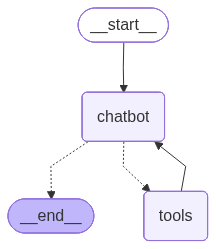

In [324]:
graph = graph_builder.compile(checkpointer=SqliteSaver(conn))
graph
# print(graph.get_graph().draw_ascii())

In [325]:
result = graph.invoke({"messages": [{"role": "user", "content": "Please make a poem about Python code."}]}, config=config)

In [327]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Please make a poem about Python code.
================================== Ai Message ==================================
Tool Calls:
  get_human_feedback (call_XVvhbFXDbcGIAUUHeoKQ4bN6)
 Call ID: call_XVvhbFXDbcGIAUUHeoKQ4bN6
  Args:
    poem: In a realm of logic and code so neat,
Where lines of Python gracefully meet,
Indentations holding secrets so tight,
Crafting solutions, brilliant and bright.

Variables dance in a structured flow,
With lists and tuples, they endlessly grow.
A function's embrace, a loop's gentle sway,
In this digital garden, we code and play.

From if statements branching out to explore,
To libraries waiting, with goodies in store.
The syntax, a melody, the debug, a plight,
Yet the joy of creation fills hearts with delight.

So here’s to the Python, elegant and wise,
A language that opens a world to the skies.
With each written line, a story is spun,
In the vast universe of code, we ar

In [328]:
snapshot = graph.get_state(config)
snapshot.interrupts

(Interrupt(value="Here is the poem, tell me what you think of it.\nIn a realm of logic and code so neat,\nWhere lines of Python gracefully meet,\nIndentations holding secrets so tight,\nCrafting solutions, brilliant and bright.\n\nVariables dance in a structured flow,\nWith lists and tuples, they endlessly grow.\nA function's embrace, a loop's gentle sway,\nIn this digital garden, we code and play.\n\nFrom if statements branching out to explore,\nTo libraries waiting, with goodies in store.\nThe syntax, a melody, the debug, a plight,\nYet the joy of creation fills hearts with delight.\n\nSo here’s to the Python, elegant and wise,\nA language that opens a world to the skies.\nWith each written line, a story is spun,\nIn the vast universe of code, we are one.", id='80a5b57b14c5319cd5dd62a1d5104a41'),)

In [329]:
snapshot.next

('tools',)

In [331]:
response = Command(resume="It looks good!")

result = graph.invoke(response, config=config)

In [332]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Please make a poem about Python code.
================================== Ai Message ==================================
Tool Calls:
  get_human_feedback (call_XVvhbFXDbcGIAUUHeoKQ4bN6)
 Call ID: call_XVvhbFXDbcGIAUUHeoKQ4bN6
  Args:
    poem: In a realm of logic and code so neat,
Where lines of Python gracefully meet,
Indentations holding secrets so tight,
Crafting solutions, brilliant and bright.

Variables dance in a structured flow,
With lists and tuples, they endlessly grow.
A function's embrace, a loop's gentle sway,
In this digital garden, we code and play.

From if statements branching out to explore,
To libraries waiting, with goodies in store.
The syntax, a melody, the debug, a plight,
Yet the joy of creation fills hearts with delight.

So here’s to the Python, elegant and wise,
A language that opens a world to the skies.
With each written line, a story is spun,
In the vast universe of code, we ar

In [333]:
snapshot = graph.get_state(config)
snapshot.next

()